In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import lightgbm as lgbm
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import KFold, StratifiedKFold
from sklearn.metrics import log_loss, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler, MinMaxScaler, OneHotEncoder

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dense, Dropout, BatchNormalization, Activation 
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras import optimizers

import warnings
warnings.filterwarnings('ignore')

import os
print(os.listdir("../input"))

import regex as re
import gc
# Any results you write to the current directory are saved as output.

['covertype_train.csv', 'sample_submission.csv', 'covertype_test.csv']


Using TensorFlow backend.


In [2]:
baseline_tree_score = 0.23092278864723115
baseline_neuralnetwork_score = 0.5480561937041435

In [4]:
train = pd.read_csv('../input/covertype_train.csv')
test = pd.read_csv('../input/covertype_test.csv')

In [5]:
train_index = train.shape[0]

### Utility Function 입니다.

In [6]:
lgbm_param =  {
    'boosting_type': 'gbdt',
    'objective': 'binary',
    'metric': 'binary_logloss',
    "learning_rate": 0.06,
    "num_leaves": 16,
    "max_depth": 6,
    "colsample_bytree": 0.7,
    "subsample": 0.8,
    "reg_alpha": 0.1,
    "reg_lambda": 0.1,
    "nthread":8
}

In [7]:
def keras_model(input_dims):
    model = Sequential()
    
    model.add(Dense(input_dims, input_dim=input_dims))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.3))
    
    model.add(Dense(input_dims//2))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.2))
    
    # output layer (y_pred)
    model.add(Dense(1))
    model.add(Activation('sigmoid'))
    
    # compile this model
    model.compile(loss='binary_crossentropy', # one may use 'mean_absolute_error' as alternative
                  optimizer='adam', metrics=['accuracy'])
    return model

def keras_history_plot(history):
    plt.plot(history.history['loss'], 'y', label='train loss')
    plt.plot(history.history['val_loss'], 'r', label='val loss')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(loc='upper right')
    plt.show()

In [8]:
def baseline_tree_cv(train):
    train_df = train.copy()
    y_value = train_df["Cover_Type"]
    del train_df["Cover_Type"], train_df["ID"]
    
    NFOLD = 5
    folds = StratifiedKFold(n_splits= NFOLD, shuffle=True, random_state=2018)

    total_score = 0
    best_iteration = 0
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, y_value)):
        train_x, train_y = train_df.iloc[train_idx], y_value.iloc[train_idx]
        valid_x, valid_y = train_df.iloc[valid_idx], y_value.iloc[valid_idx]

        evals_result_dict = {} 
        dtrain = lgbm.Dataset(train_x, label=train_y)
        dvalid = lgbm.Dataset(valid_x, label=valid_y)

        clf = lgbm.train(lgbm_param, train_set=dtrain, num_boost_round=3000, valid_sets=[dtrain, dvalid],
                               early_stopping_rounds=200, evals_result=evals_result_dict, verbose_eval=500)

        predict = clf.predict(valid_x)
        cv_score = log_loss(valid_y, predict )
        total_score += cv_score
        best_iteration = max(best_iteration, clf.best_iteration)
        print('Fold {} LogLoss : {}'.format(n_fold + 1, cv_score ))
        lgbm.plot_metric(evals_result_dict)
        plt.show()
        
    print("Best Iteration", best_iteration)
    print("Total LogLoss", total_score / NFOLD)
    print("Baseline model Score Diff", total_score / NFOLD - baseline_tree_score)
    
    del train_df
    
    return best_iteration

def baseline_keras_cv(train):
    train_df = train.copy()
    y_value = train_df['Cover_Type']
    del train_df['Cover_Type'], train_df['ID']
    
    model = keras_model(train_df.shape[1])
    callbacks = [
            EarlyStopping(
                patience=10,
                verbose=10)
        ]

    NFOLD = 5
    folds = StratifiedKFold(n_splits= NFOLD, shuffle=True, random_state=2018)

    total_score = 0
    best_epoch = 0
    for n_fold, (train_idx, valid_idx) in enumerate(folds.split(train_df, y_value)):
        train_x, train_y = train_df.iloc[train_idx], y_value.iloc[train_idx]
        valid_x, valid_y = train_df.iloc[valid_idx], y_value.iloc[valid_idx]

        history = model.fit(train_x.values, train_y.values, nb_epoch=30, batch_size = 64, validation_data=(valid_x.values, valid_y.values), 
                            verbose=1, callbacks=callbacks)

        keras_history_plot(history)
        predict = model.predict(valid_x.values)
        null_count = np.sum(pd.isnull(predict) )
        if null_count > 0:
            print("Null Prediction Error: ", null_count)
            predict[pd.isnull(predict)] = predict[~pd.isnull(predict)].mean()

        cv_score = log_loss(valid_y, predict )
        total_score += cv_score
        best_epoch = max(best_epoch, np.max(history.epoch))
        print('Fold {} LogLoss : {}'.format(n_fold + 1, cv_score ))
        
    print("Best Epoch: ", best_epoch)
    print("Total LogLoss", total_score/NFOLD)
    print("Baseline model Score Diff", total_score/NFOLD - baseline_neuralnetwork_score)

# 이번 Kernel에서는 기본적인 Data 변환을 실습하도록 하겠습니다.

제가 설명하는동안 직접 코드 실행 시키시면서 이것저것 해보시는 것이 좋습니다!

### 값이 너무 큰 Elevation Feature Log Transform 수행

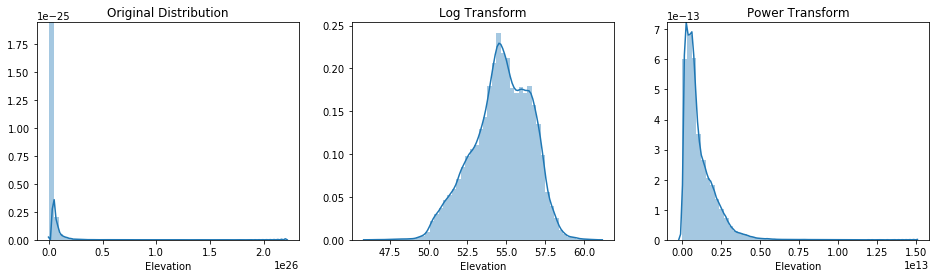

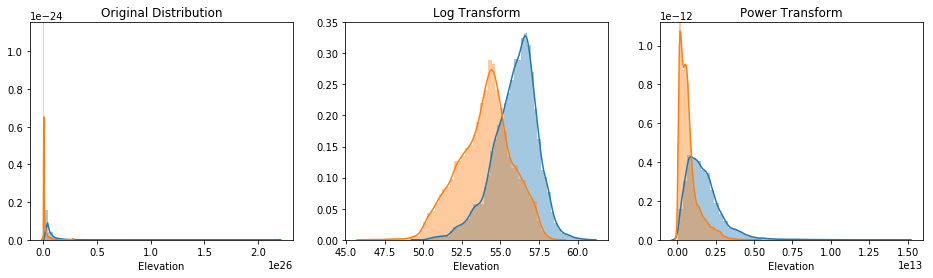

In [9]:
all_data = pd.concat([train,test])

fig, axes = plt.subplots(ncols=3, figsize=(16,4))
sns.distplot(all_data['Elevation'],ax=axes[0])
sns.distplot(np.log1p(all_data['Elevation']),ax=axes[1])
sns.distplot(np.sqrt(all_data['Elevation']),ax=axes[2])
axes[0].set_title('Original Distribution')
axes[1].set_title('Log Transform')
axes[2].set_title('Power Transform')
plt.show()

fig, axes = plt.subplots(ncols=3, figsize=(16,4))
sns.distplot(all_data.loc[all_data['Cover_Type']==0, 'Elevation'],ax=axes[0])
sns.distplot(all_data.loc[all_data['Cover_Type']==1, 'Elevation'],ax=axes[0])
sns.distplot(np.log1p(all_data.loc[all_data['Cover_Type']==0, 'Elevation']),ax=axes[1])
sns.distplot(np.log1p(all_data.loc[all_data['Cover_Type']==1, 'Elevation']),ax=axes[1])
sns.distplot(np.sqrt(all_data.loc[all_data['Cover_Type']==0, 'Elevation']),ax=axes[2])
sns.distplot(np.sqrt(all_data.loc[all_data['Cover_Type']==1, 'Elevation']),ax=axes[2])

axes[0].set_title('Original Distribution')
axes[1].set_title('Log Transform')
axes[2].set_title('Power Transform')
plt.show()

In [10]:
del all_data['oil_Type']
all_data['Elevation'] = np.log1p(all_data['Elevation'])

In [11]:
category_feature = []
for col in all_data.loc[:, all_data.dtypes=='object'].columns:
    all_data[col] = all_data[col].factorize()[0]
    category_feature.append(col)
    
train_df = all_data.iloc[:train_index]
test_df = all_data.iloc[train_index:]

### Tree Model에서는 Log Trasnform 한다고 성능차이가 크지 않았습니다.

Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.322618	valid_1's binary_logloss: 0.340456
[1000]	training's binary_logloss: 0.269949	valid_1's binary_logloss: 0.298574
[1500]	training's binary_logloss: 0.234456	valid_1's binary_logloss: 0.273144
[2000]	training's binary_logloss: 0.20669	valid_1's binary_logloss: 0.254343
[2500]	training's binary_logloss: 0.184297	valid_1's binary_logloss: 0.240719
[3000]	training's binary_logloss: 0.16398	valid_1's binary_logloss: 0.229019
Did not meet early stopping. Best iteration is:
[3000]	training's binary_logloss: 0.16398	valid_1's binary_logloss: 0.229019
Fold 1 LogLoss : 0.22901927102276093


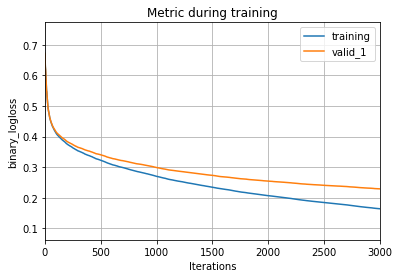

Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.322743	valid_1's binary_logloss: 0.341372
[1000]	training's binary_logloss: 0.269887	valid_1's binary_logloss: 0.301094
[1500]	training's binary_logloss: 0.233681	valid_1's binary_logloss: 0.274772
[2000]	training's binary_logloss: 0.206387	valid_1's binary_logloss: 0.256847
[2500]	training's binary_logloss: 0.183741	valid_1's binary_logloss: 0.24299
[3000]	training's binary_logloss: 0.164997	valid_1's binary_logloss: 0.231902
Did not meet early stopping. Best iteration is:
[3000]	training's binary_logloss: 0.164997	valid_1's binary_logloss: 0.231902
Fold 2 LogLoss : 0.23190226061572888


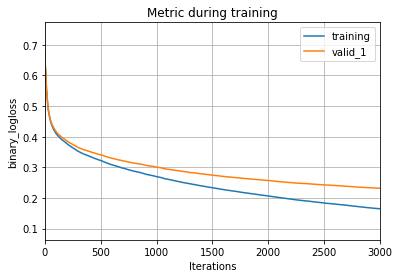

Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.321398	valid_1's binary_logloss: 0.345149
[1000]	training's binary_logloss: 0.26541	valid_1's binary_logloss: 0.301565
[1500]	training's binary_logloss: 0.229903	valid_1's binary_logloss: 0.277486
[2000]	training's binary_logloss: 0.202644	valid_1's binary_logloss: 0.25934
[2500]	training's binary_logloss: 0.181471	valid_1's binary_logloss: 0.246233
[3000]	training's binary_logloss: 0.162585	valid_1's binary_logloss: 0.233815
Did not meet early stopping. Best iteration is:
[3000]	training's binary_logloss: 0.162585	valid_1's binary_logloss: 0.233815
Fold 3 LogLoss : 0.23381459511935512


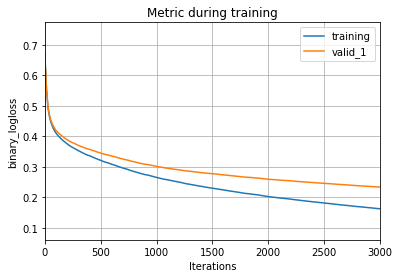

Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.321662	valid_1's binary_logloss: 0.340348
[1000]	training's binary_logloss: 0.269605	valid_1's binary_logloss: 0.300388
[1500]	training's binary_logloss: 0.232056	valid_1's binary_logloss: 0.273395
[2000]	training's binary_logloss: 0.206384	valid_1's binary_logloss: 0.257606
[2500]	training's binary_logloss: 0.184376	valid_1's binary_logloss: 0.243677
[3000]	training's binary_logloss: 0.164745	valid_1's binary_logloss: 0.231913
Did not meet early stopping. Best iteration is:
[3000]	training's binary_logloss: 0.164745	valid_1's binary_logloss: 0.231913
Fold 4 LogLoss : 0.23191338412672755


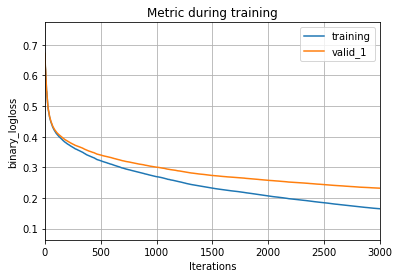

Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.322403	valid_1's binary_logloss: 0.342729
[1000]	training's binary_logloss: 0.270602	valid_1's binary_logloss: 0.303578
[1500]	training's binary_logloss: 0.234616	valid_1's binary_logloss: 0.277519
[2000]	training's binary_logloss: 0.205339	valid_1's binary_logloss: 0.257627
[2500]	training's binary_logloss: 0.183866	valid_1's binary_logloss: 0.24439
[3000]	training's binary_logloss: 0.164639	valid_1's binary_logloss: 0.233154
Did not meet early stopping. Best iteration is:
[3000]	training's binary_logloss: 0.164639	valid_1's binary_logloss: 0.233154
Fold 5 LogLoss : 0.23315423645568165


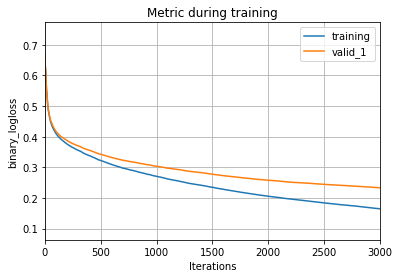

Best Iteration 3000
Total LogLoss 0.23196074946805081
Baseline model Score Diff 0.0010379608208196667


3000

In [12]:
baseline_tree_cv(train_df)

### 같은 Feature를 NeuralNetwork에 적용해 보도록 하겠습니다.

In [13]:
all_data = pd.concat([train,test])

del all_data['oil_Type']
all_column_set = set(all_data.columns)
category_feature = []
for col in all_data.loc[:, all_data.dtypes=='object'].columns:
    all_data[col] = all_data[col].factorize()[0]
    category_feature.append(col)
    
numerical_feature = list(all_column_set - set(category_feature) - set(['Cover_Type','ID']))

all_data['Aspect'].fillna(all_data['Aspect'].mean(), inplace=True)
all_data['Elevation'] = np.log1p(all_data['Elevation'])

train_df = all_data.iloc[:train_index]
test_df = all_data.iloc[train_index:]

sc = StandardScaler()
train_df[numerical_feature] = sc.fit_transform(train_df[numerical_feature])
test_df[numerical_feature] = sc.transform(test_df[numerical_feature] )

Train on 71261 samples, validate on 17816 samples
Epoch 1/30
71261/71261 [==============================] - 4s 63us/step - loss: 0.5826 - acc: 0.6840 - val_loss: 0.4929 - val_acc: 0.7688
Epoch 2/30
71261/71261 [==============================] - 4s 51us/step - loss: 0.5259 - acc: 0.7431 - val_loss: 0.4881 - val_acc: 0.7735
Epoch 3/30
71261/71261 [==============================] - 4s 51us/step - loss: 0.5201 - acc: 0.7502 - val_loss: 0.4871 - val_acc: 0.7736
Epoch 4/30
71261/71261 [==============================] - 4s 52us/step - loss: 0.5164 - acc: 0.7528 - val_loss: 0.4865 - val_acc: 0.7744
Epoch 5/30
71261/71261 [==============================] - 4s 52us/step - loss: 0.5125 - acc: 0.7581 - val_loss: 0.4858 - val_acc: 0.7769
Epoch 6/30
71261/71261 [==============================] - 4s 52us/step - loss: 0.5080 - acc: 0.7635 - val_loss: 0.4838 - val_acc: 0.7764
Epoch 7/30
71261/71261 [==============================] - 4s 51us/step - loss: 0.5081 - acc: 0.7639 - val_loss: 0.4826 - val_acc

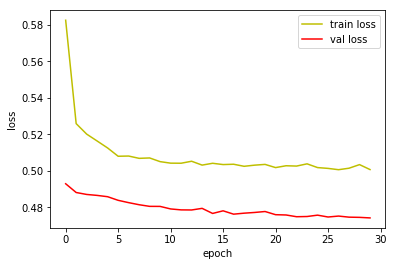

Fold 1 LogLoss : 0.47420177832689375
Train on 71261 samples, validate on 17816 samples
Epoch 1/30
71261/71261 [==============================] - 5s 69us/step - loss: 0.5027 - acc: 0.7665 - val_loss: 0.4753 - val_acc: 0.7777
Epoch 2/30
71261/71261 [==============================] - 6s 78us/step - loss: 0.5025 - acc: 0.7678 - val_loss: 0.4747 - val_acc: 0.7800
Epoch 3/30
71261/71261 [==============================] - 4s 54us/step - loss: 0.5014 - acc: 0.7682 - val_loss: 0.4735 - val_acc: 0.7806
Epoch 4/30
71261/71261 [==============================] - 4s 51us/step - loss: 0.5013 - acc: 0.7682 - val_loss: 0.4731 - val_acc: 0.7789
Epoch 5/30
71261/71261 [==============================] - 4s 51us/step - loss: 0.5005 - acc: 0.7685 - val_loss: 0.4742 - val_acc: 0.7794
Epoch 6/30
71261/71261 [==============================] - 4s 51us/step - loss: 0.5013 - acc: 0.7673 - val_loss: 0.4725 - val_acc: 0.7793
Epoch 7/30
71261/71261 [==============================] - 4s 51us/step - loss: 0.5002 - acc

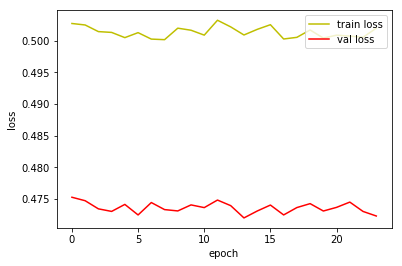

Fold 2 LogLoss : 0.4723358134999905
Train on 71262 samples, validate on 17815 samples
Epoch 1/30
71262/71262 [==============================] - 4s 51us/step - loss: 0.4991 - acc: 0.7707 - val_loss: 0.4743 - val_acc: 0.7804
Epoch 2/30
71262/71262 [==============================] - 4s 51us/step - loss: 0.5007 - acc: 0.7679 - val_loss: 0.4743 - val_acc: 0.7797
Epoch 3/30
71262/71262 [==============================] - 4s 52us/step - loss: 0.4991 - acc: 0.7694 - val_loss: 0.4747 - val_acc: 0.7801
Epoch 4/30
71262/71262 [==============================] - 4s 52us/step - loss: 0.5013 - acc: 0.7673 - val_loss: 0.4769 - val_acc: 0.7801
Epoch 5/30
71262/71262 [==============================] - 4s 52us/step - loss: 0.5016 - acc: 0.7667 - val_loss: 0.4752 - val_acc: 0.7803
Epoch 6/30
71262/71262 [==============================] - 4s 52us/step - loss: 0.5013 - acc: 0.7672 - val_loss: 0.4755 - val_acc: 0.7793
Epoch 7/30
71262/71262 [==============================] - 4s 51us/step - loss: 0.5004 - acc:

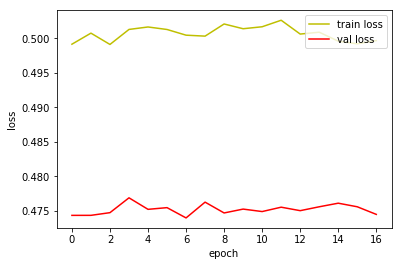

Fold 3 LogLoss : 0.47448027531470405
Train on 71262 samples, validate on 17815 samples
Epoch 1/30
71262/71262 [==============================] - 4s 51us/step - loss: 0.5026 - acc: 0.7659 - val_loss: 0.4724 - val_acc: 0.7835
Epoch 2/30
71262/71262 [==============================] - 4s 51us/step - loss: 0.5011 - acc: 0.7669 - val_loss: 0.4708 - val_acc: 0.7853
Epoch 3/30
71262/71262 [==============================] - 4s 51us/step - loss: 0.5011 - acc: 0.7667 - val_loss: 0.4701 - val_acc: 0.7844
Epoch 4/30
71262/71262 [==============================] - 4s 51us/step - loss: 0.5020 - acc: 0.7677 - val_loss: 0.4702 - val_acc: 0.7846
Epoch 5/30
71262/71262 [==============================] - 4s 52us/step - loss: 0.5030 - acc: 0.7655 - val_loss: 0.4703 - val_acc: 0.7842
Epoch 6/30
71262/71262 [==============================] - 4s 52us/step - loss: 0.5007 - acc: 0.7678 - val_loss: 0.4703 - val_acc: 0.7837
Epoch 7/30
71262/71262 [==============================] - 4s 51us/step - loss: 0.5020 - acc

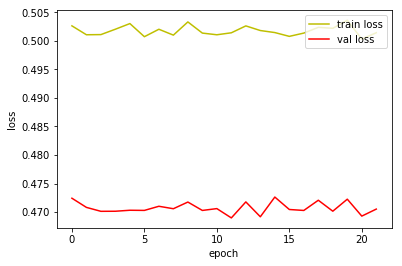

Fold 4 LogLoss : 0.47053464857059335
Train on 71262 samples, validate on 17815 samples
Epoch 1/30
71262/71262 [==============================] - 4s 52us/step - loss: 0.5021 - acc: 0.7660 - val_loss: 0.4717 - val_acc: 0.7837
Epoch 2/30
71262/71262 [==============================] - 4s 52us/step - loss: 0.5008 - acc: 0.7695 - val_loss: 0.4733 - val_acc: 0.7810
Epoch 3/30
71262/71262 [==============================] - 4s 51us/step - loss: 0.5006 - acc: 0.7669 - val_loss: 0.4720 - val_acc: 0.7836
Epoch 4/30
71262/71262 [==============================] - 4s 51us/step - loss: 0.5014 - acc: 0.7674 - val_loss: 0.4735 - val_acc: 0.7841
Epoch 5/30
71262/71262 [==============================] - 4s 52us/step - loss: 0.5006 - acc: 0.7692 - val_loss: 0.4726 - val_acc: 0.7829
Epoch 6/30
71262/71262 [==============================] - 4s 51us/step - loss: 0.4996 - acc: 0.7677 - val_loss: 0.4717 - val_acc: 0.7836
Epoch 7/30
71262/71262 [==============================] - 4s 52us/step - loss: 0.5006 - acc

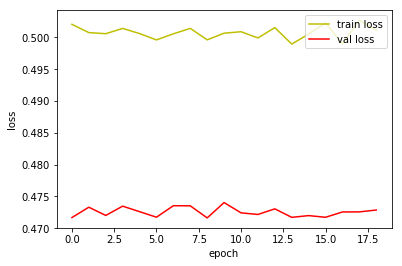

Fold 5 LogLoss : 0.4728679312669225
Best Epoch:  29
Total LogLoss 0.4728840893958209
Baseline model Score Diff -0.07517210430832261


In [14]:
baseline_keras_cv(train_df)

## Neural Network에서는 아주 큰 값에 Log Transform 하였을 때 많이 개선된 것을 볼 수 있습니다.

## EDA 할 때 Numerical Data에 아주 큰 값이 들어 있는 것을 또 볼 수 있었습니다.

In [15]:
all_data = pd.concat([train,test])

del all_data['oil_Type']
all_column_set = set(all_data.columns)
category_feature = []
for col in all_data.loc[:, all_data.dtypes=='object'].columns:
    all_data[col] = all_data[col].factorize()[0]
    category_feature.append(col)
    
numerical_feature = list(all_column_set - set(category_feature) - set(['Cover_Type','ID']))

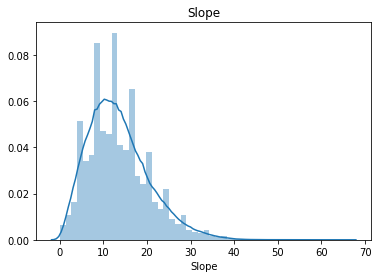

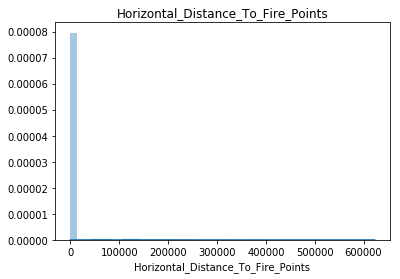

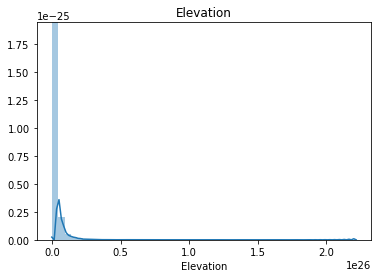

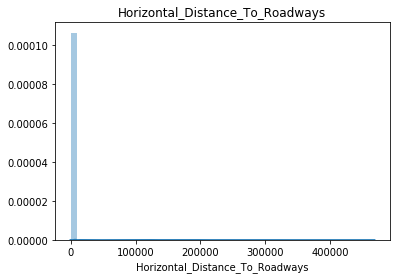

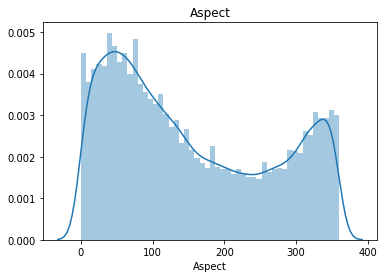

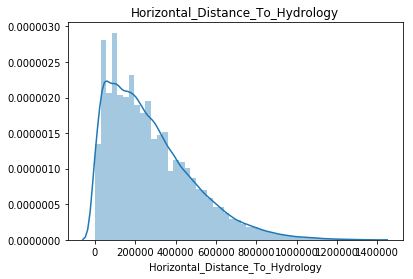

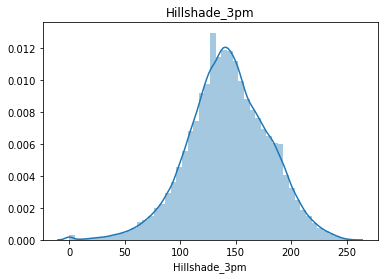

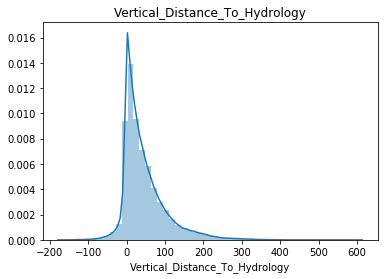

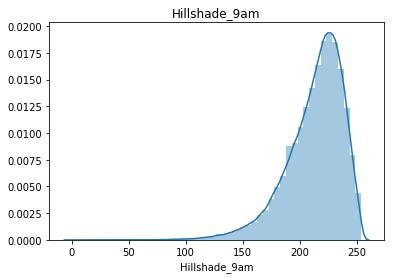

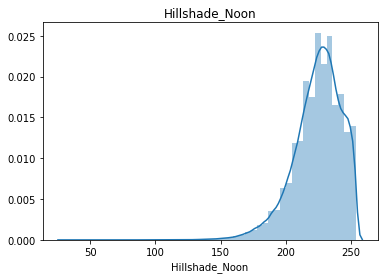

In [16]:
for col in numerical_feature:
    sns.distplot(all_data.loc[all_data[col].notnull(), col])
    plt.title(col)
    plt.show()

### 아래 2개의 Feature가 이상합니다.

In [17]:
['Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Roadways']

['Horizontal_Distance_To_Fire_Points', 'Horizontal_Distance_To_Roadways']

### Graph가 어느 순간에 꺽이는 것을 볼 수 있습니다.

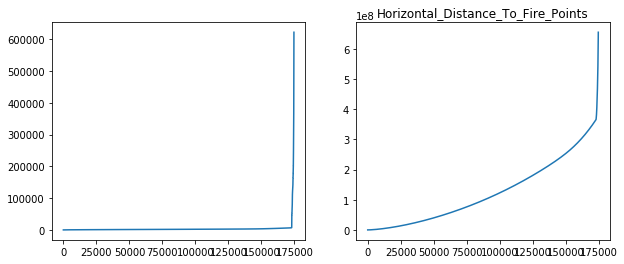

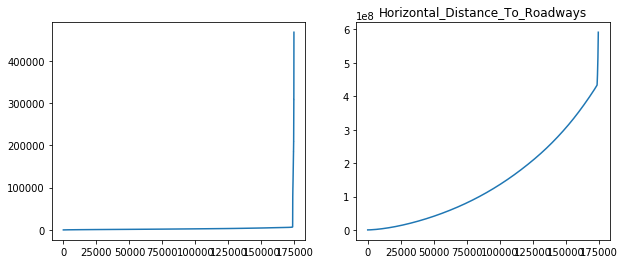

In [18]:
fig, axes = plt.subplots(ncols=2, figsize=(10,4))
axes[0].plot(np.sort(all_data['Horizontal_Distance_To_Fire_Points']))
axes[1].plot(np.cumsum(np.sort(all_data['Horizontal_Distance_To_Fire_Points'])))
plt.title('Horizontal_Distance_To_Fire_Points')
plt.show()

fig, axes = plt.subplots(ncols=2, figsize=(10,4))
axes[0].plot(np.sort(all_data['Horizontal_Distance_To_Roadways']))
axes[1].plot(np.cumsum(np.sort(all_data['Horizontal_Distance_To_Roadways'])))
plt.title('Horizontal_Distance_To_Roadways')
plt.show()

In [19]:
for percent in np.arange(99,100,0.1):
    print(np.percentile(all_data['Horizontal_Distance_To_Fire_Points'],percent))

6930.899999999994
47363.22000000207
65844.0
105450.0
121112.15999999922
134976.0
158875.63999999734
188097.0
244214.21999992046
340312.7599999504


In [20]:
for percent in np.arange(99,100,0.1):
    print(np.percentile(all_data['Horizontal_Distance_To_Roadways'],percent))

6367.0
6439.510000000009
6547.0
6678.729999999981
6886.699999999837
82986.49999999488
112336.67999999074
143004.0
179298.0
227799.0


In [21]:
def outlier_binary(frame, col, outlier_range):
    outlier_feature = col + '_Outlier'
    frame[outlier_feature] = 0
    frame.loc[frame[col] > outlier_range, outlier_feature] = 1
    return frame

In [22]:
all_data = outlier_binary(all_data, 'Horizontal_Distance_To_Fire_Points', 10000)
all_data = outlier_binary(all_data, 'Horizontal_Distance_To_Roadways', 10000)

In [23]:
all_data['Aspect'].fillna(all_data['Aspect'].mean(), inplace=True)
all_data['Elevation'] = np.log1p(all_data['Elevation'])

train_df = all_data.iloc[:train_index]
test_df = all_data.iloc[train_index:]

sc = StandardScaler()
train_df[numerical_feature] = sc.fit_transform(train_df[numerical_feature])
test_df[numerical_feature] = sc.transform(test_df[numerical_feature] )

Train on 71261 samples, validate on 17816 samples
Epoch 1/30
71261/71261 [==============================] - 5s 65us/step - loss: 0.5924 - acc: 0.6866 - val_loss: 0.4981 - val_acc: 0.7720
Epoch 2/30
71261/71261 [==============================] - 4s 54us/step - loss: 0.5250 - acc: 0.7512 - val_loss: 0.4944 - val_acc: 0.7723
Epoch 3/30
71261/71261 [==============================] - 4s 54us/step - loss: 0.5144 - acc: 0.7580 - val_loss: 0.4910 - val_acc: 0.7719
Epoch 4/30
71261/71261 [==============================] - 4s 54us/step - loss: 0.5107 - acc: 0.7603 - val_loss: 0.4934 - val_acc: 0.7727
Epoch 5/30
71261/71261 [==============================] - 4s 57us/step - loss: 0.5077 - acc: 0.7618 - val_loss: 0.4909 - val_acc: 0.7750
Epoch 6/30
71261/71261 [==============================] - 4s 59us/step - loss: 0.5073 - acc: 0.7613 - val_loss: 0.4858 - val_acc: 0.7748
Epoch 7/30
71261/71261 [==============================] - 4s 54us/step - loss: 0.5067 - acc: 0.7635 - val_loss: 0.4880 - val_acc

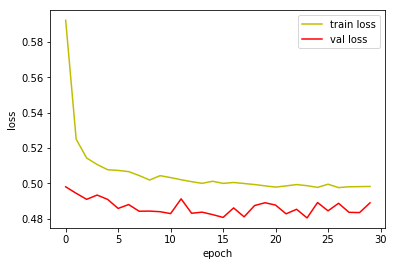

Fold 1 LogLoss : 0.48898270627593293
Train on 71261 samples, validate on 17816 samples
Epoch 1/30
71261/71261 [==============================] - 4s 53us/step - loss: 0.4989 - acc: 0.7674 - val_loss: 0.4837 - val_acc: 0.7778
Epoch 2/30
71261/71261 [==============================] - 4s 53us/step - loss: 0.4985 - acc: 0.7664 - val_loss: 0.4797 - val_acc: 0.7798
Epoch 3/30
71261/71261 [==============================] - 4s 52us/step - loss: 0.4986 - acc: 0.7679 - val_loss: 0.4829 - val_acc: 0.7787
Epoch 4/30
71261/71261 [==============================] - 4s 52us/step - loss: 0.4996 - acc: 0.7656 - val_loss: 0.4846 - val_acc: 0.7789
Epoch 5/30
71261/71261 [==============================] - 4s 53us/step - loss: 0.4978 - acc: 0.7666 - val_loss: 0.4860 - val_acc: 0.7753
Epoch 6/30
71261/71261 [==============================] - 4s 53us/step - loss: 0.4980 - acc: 0.7657 - val_loss: 0.4795 - val_acc: 0.7787
Epoch 7/30
71261/71261 [==============================] - 4s 54us/step - loss: 0.4993 - acc

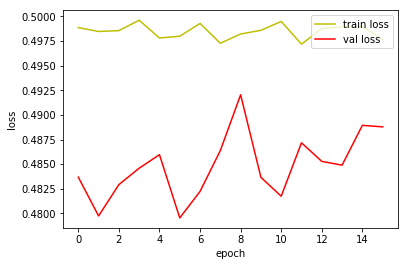

Fold 2 LogLoss : 0.4887836846444262
Train on 71262 samples, validate on 17815 samples
Epoch 1/30
71262/71262 [==============================] - 4s 54us/step - loss: 0.4983 - acc: 0.7683 - val_loss: 0.4910 - val_acc: 0.7743
Epoch 2/30
71262/71262 [==============================] - 4s 54us/step - loss: 0.4976 - acc: 0.7667 - val_loss: 0.4910 - val_acc: 0.7755
Epoch 3/30
71262/71262 [==============================] - 4s 55us/step - loss: 0.4992 - acc: 0.7674 - val_loss: 0.4912 - val_acc: 0.7752
Epoch 4/30
71262/71262 [==============================] - 4s 54us/step - loss: 0.4962 - acc: 0.7679 - val_loss: 0.4924 - val_acc: 0.7752
Epoch 5/30
71262/71262 [==============================] - 4s 54us/step - loss: 0.4977 - acc: 0.7672 - val_loss: 0.4897 - val_acc: 0.7762
Epoch 6/30
71262/71262 [==============================] - 4s 56us/step - loss: 0.4960 - acc: 0.7677 - val_loss: 0.4866 - val_acc: 0.7766
Epoch 7/30
71262/71262 [==============================] - 4s 56us/step - loss: 0.4962 - acc:

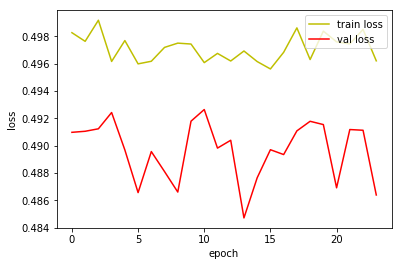

Fold 3 LogLoss : 0.4863891192356926
Train on 71262 samples, validate on 17815 samples
Epoch 1/30
71262/71262 [==============================] - 4s 53us/step - loss: 0.4970 - acc: 0.7674 - val_loss: 0.4840 - val_acc: 0.7804
Epoch 2/30
71262/71262 [==============================] - 4s 53us/step - loss: 0.4967 - acc: 0.7671 - val_loss: 0.4892 - val_acc: 0.7767
Epoch 3/30
71262/71262 [==============================] - 4s 53us/step - loss: 0.4966 - acc: 0.7662 - val_loss: 0.4858 - val_acc: 0.7793
Epoch 4/30
71262/71262 [==============================] - 4s 53us/step - loss: 0.4972 - acc: 0.7676 - val_loss: 0.4844 - val_acc: 0.7782
Epoch 5/30
71262/71262 [==============================] - 4s 54us/step - loss: 0.4978 - acc: 0.7654 - val_loss: 0.4860 - val_acc: 0.7775
Epoch 6/30
71262/71262 [==============================] - 4s 54us/step - loss: 0.4964 - acc: 0.7669 - val_loss: 0.4873 - val_acc: 0.7792
Epoch 7/30
71262/71262 [==============================] - 4s 54us/step - loss: 0.4980 - acc:

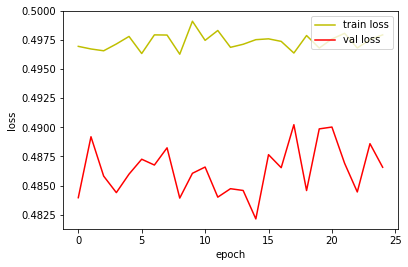

Fold 4 LogLoss : 0.486570395562963
Train on 71262 samples, validate on 17815 samples
Epoch 1/30
71262/71262 [==============================] - 4s 54us/step - loss: 0.4975 - acc: 0.7673 - val_loss: 0.4845 - val_acc: 0.7778
Epoch 2/30
71262/71262 [==============================] - 4s 54us/step - loss: 0.4968 - acc: 0.7669 - val_loss: 0.4888 - val_acc: 0.7742
Epoch 3/30
71262/71262 [==============================] - 4s 57us/step - loss: 0.4968 - acc: 0.7694 - val_loss: 0.4885 - val_acc: 0.7749
Epoch 4/30
71262/71262 [==============================] - 4s 54us/step - loss: 0.4976 - acc: 0.7669 - val_loss: 0.4924 - val_acc: 0.7712
Epoch 5/30
71262/71262 [==============================] - 4s 53us/step - loss: 0.4959 - acc: 0.7685 - val_loss: 0.4867 - val_acc: 0.7765
Epoch 6/30
71262/71262 [==============================] - 4s 53us/step - loss: 0.4959 - acc: 0.7675 - val_loss: 0.4838 - val_acc: 0.7793
Epoch 7/30
71262/71262 [==============================] - 4s 54us/step - loss: 0.4954 - acc: 

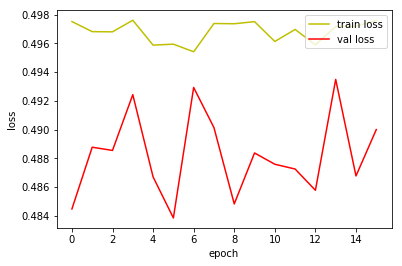

Fold 5 LogLoss : 0.48999631474726063
Best Epoch:  29
Total LogLoss 0.4881444440932551
Baseline model Score Diff -0.05991174961088841


In [24]:
baseline_keras_cv(train_df)

## 뭔가 이렇게만 outlier binary feature 하나로만은 좀 아쉽습니다.
좀 더 살펴보도록 하겠습니다.

### Horizontal_Distance_To_Roadways의 분포를 다시한번 살펴봅니다.
자세히 보니 큰 값과 작은 값의 분포가 거의 비슷합니다.<br>
큰 값의 중앙값과 작은 값의 중앙값의 비율로 큰 값을 나눠 줍니다.<br>

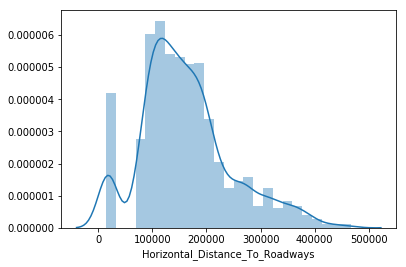

148932.0 2165.0 68.79076212471132


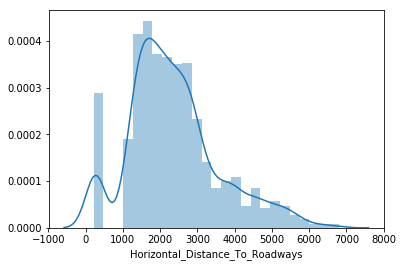

In [25]:
all_data = pd.concat([train, test])
hdroad_outlier_index = all_data['Horizontal_Distance_To_Roadways']>=10000

sns.distplot(all_data.loc[hdroad_outlier_index, 'Horizontal_Distance_To_Roadways'])
plt.show()

hdroad_outlier_median =  all_data.loc[hdroad_outlier_index, 'Horizontal_Distance_To_Roadways'].median()
hdroad_normal_median = all_data.loc[all_data['Horizontal_Distance_To_Roadways']<10000, 'Horizontal_Distance_To_Roadways'].median()
print(hdroad_outlier_median, hdroad_normal_median, hdroad_outlier_median/hdroad_normal_median)
hdroad_outlier_ratio = hdroad_outlier_median/hdroad_normal_median

sns.distplot(all_data.loc[hdroad_outlier_index, 'Horizontal_Distance_To_Roadways']/hdroad_outlier_ratio)
plt.show()

### Horizontal_Distance_To_Roadways 분포를 다시 그려보니 큰 값이 모두 제거 되었습니다.
Target값도 둘 사이의 분포가 달라서 Algorithm 성능이 좋게 나올 것 같습니다.

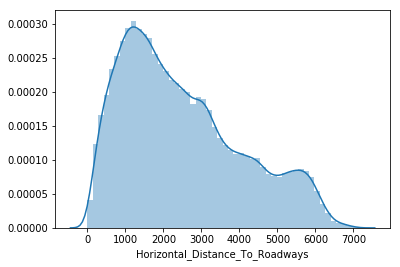

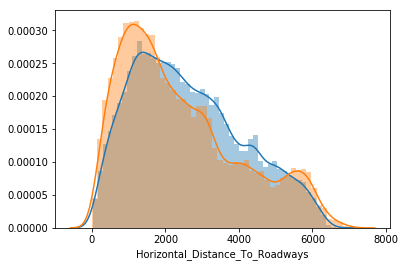

In [26]:
all_data.loc[hdroad_outlier_index, 'Horizontal_Distance_To_Roadways'] = all_data.loc[hdroad_outlier_index, 'Horizontal_Distance_To_Roadways']/hdroad_outlier_ratio
sns.distplot(all_data['Horizontal_Distance_To_Roadways'])
plt.show()
sns.distplot(all_data.loc[all_data['Cover_Type']==0,'Horizontal_Distance_To_Roadways'])
sns.distplot(all_data.loc[all_data['Cover_Type']==1,'Horizontal_Distance_To_Roadways'])
plt.show()

### 마찬가지로 Horizontal_Distance_To_Fire_Points 도 살펴봅니다.

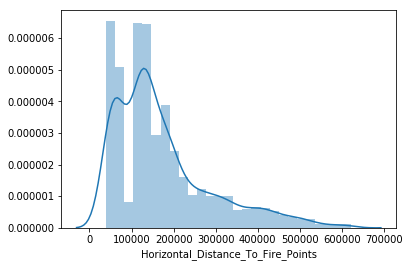

136990.0 1842.0 74.37024972855592


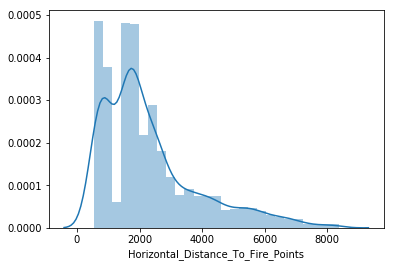

In [27]:
all_data = pd.concat([train, test])
hdfpoint_outlier_index = all_data['Horizontal_Distance_To_Fire_Points']>=10000

sns.distplot(all_data.loc[hdfpoint_outlier_index, 'Horizontal_Distance_To_Fire_Points'])
plt.show()

hdfpoint_outlier_median =  all_data.loc[hdfpoint_outlier_index, 'Horizontal_Distance_To_Fire_Points'].median()
hdfpoint_normal_median = all_data.loc[all_data['Horizontal_Distance_To_Fire_Points']<10000, 'Horizontal_Distance_To_Fire_Points'].median()
print(hdfpoint_outlier_median, hdfpoint_normal_median, hdfpoint_outlier_median/hdfpoint_normal_median)
hdfpoint_outlier_ratio = hdfpoint_outlier_median/hdfpoint_normal_median

sns.distplot(all_data.loc[hdfpoint_outlier_index, 'Horizontal_Distance_To_Fire_Points']/hdfpoint_outlier_ratio)
plt.show()

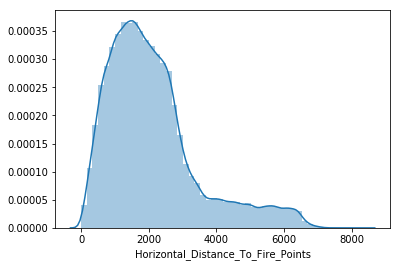

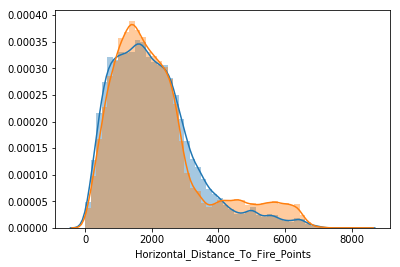

In [28]:
all_data.loc[hdfpoint_outlier_index, 'Horizontal_Distance_To_Fire_Points'] = all_data.loc[hdfpoint_outlier_index, 'Horizontal_Distance_To_Fire_Points']/hdfpoint_outlier_ratio
sns.distplot(all_data['Horizontal_Distance_To_Fire_Points'])
plt.show()
sns.distplot(all_data.loc[all_data['Cover_Type']==0,'Horizontal_Distance_To_Fire_Points'])
sns.distplot(all_data.loc[all_data['Cover_Type']==1,'Horizontal_Distance_To_Fire_Points'])
plt.show()

In [29]:
def outlier_divide_ratio(frame, col, outlier_range):
    outlier_index = frame[col] >= outlier_range
    outlier_median =  frame.loc[outlier_index, col].median()
    normal_median = frame.loc[frame[col] < outlier_range, col].median()
    outlier_ratio = outlier_median / normal_median
    
    frame.loc[outlier_index, col] = frame.loc[outlier_index, col]/outlier_ratio
    return frame

Train on 71261 samples, validate on 17816 samples
Epoch 1/30
71261/71261 [==============================] - 5s 68us/step - loss: 0.5969 - acc: 0.6680 - val_loss: 0.4937 - val_acc: 0.7723
Epoch 2/30
71261/71261 [==============================] - 4s 54us/step - loss: 0.5160 - acc: 0.7586 - val_loss: 0.4832 - val_acc: 0.7797
Epoch 3/30
71261/71261 [==============================] - 4s 54us/step - loss: 0.5066 - acc: 0.7651 - val_loss: 0.4759 - val_acc: 0.7819
Epoch 4/30
71261/71261 [==============================] - 4s 54us/step - loss: 0.5008 - acc: 0.7667 - val_loss: 0.4723 - val_acc: 0.7820
Epoch 5/30
71261/71261 [==============================] - 4s 55us/step - loss: 0.4985 - acc: 0.7714 - val_loss: 0.4698 - val_acc: 0.7856
Epoch 6/30
71261/71261 [==============================] - 4s 55us/step - loss: 0.4960 - acc: 0.7711 - val_loss: 0.4665 - val_acc: 0.7879
Epoch 7/30
71261/71261 [==============================] - 4s 55us/step - loss: 0.4948 - acc: 0.7724 - val_loss: 0.4646 - val_acc

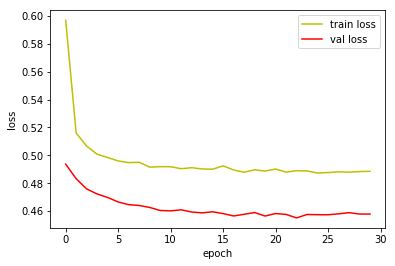

Fold 1 LogLoss : 0.45787134948523356
Train on 71261 samples, validate on 17816 samples
Epoch 1/30
71261/71261 [==============================] - 4s 56us/step - loss: 0.4875 - acc: 0.7742 - val_loss: 0.4562 - val_acc: 0.7927
Epoch 2/30
71261/71261 [==============================] - 4s 54us/step - loss: 0.4883 - acc: 0.7747 - val_loss: 0.4551 - val_acc: 0.7925
Epoch 3/30
71261/71261 [==============================] - 5s 67us/step - loss: 0.4884 - acc: 0.7744 - val_loss: 0.4555 - val_acc: 0.7929
Epoch 4/30
71261/71261 [==============================] - 5s 77us/step - loss: 0.4881 - acc: 0.7746 - val_loss: 0.4564 - val_acc: 0.7932
Epoch 5/30
71261/71261 [==============================] - 6s 82us/step - loss: 0.4862 - acc: 0.7759 - val_loss: 0.4556 - val_acc: 0.7936
Epoch 6/30
71261/71261 [==============================] - 5s 66us/step - loss: 0.4874 - acc: 0.7750 - val_loss: 0.4575 - val_acc: 0.7932
Epoch 7/30
71261/71261 [==============================] - 4s 63us/step - loss: 0.4878 - acc

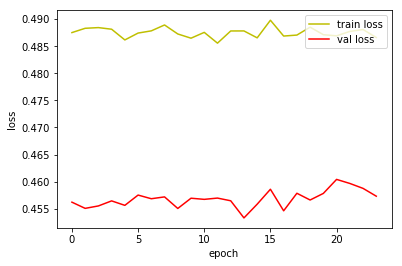

Fold 2 LogLoss : 0.45731508547121585
Train on 71262 samples, validate on 17815 samples
Epoch 1/30
71262/71262 [==============================] - 4s 61us/step - loss: 0.4854 - acc: 0.7756 - val_loss: 0.4605 - val_acc: 0.7889
Epoch 2/30
71262/71262 [==============================] - 4s 61us/step - loss: 0.4862 - acc: 0.7759 - val_loss: 0.4610 - val_acc: 0.7884
Epoch 3/30
71262/71262 [==============================] - 4s 60us/step - loss: 0.4837 - acc: 0.7778 - val_loss: 0.4588 - val_acc: 0.7889
Epoch 4/30
71262/71262 [==============================] - 4s 61us/step - loss: 0.4842 - acc: 0.7769 - val_loss: 0.4591 - val_acc: 0.7880
Epoch 5/30
71262/71262 [==============================] - 4s 60us/step - loss: 0.4845 - acc: 0.7769 - val_loss: 0.4584 - val_acc: 0.7885
Epoch 6/30
71262/71262 [==============================] - 4s 59us/step - loss: 0.4868 - acc: 0.7756 - val_loss: 0.4589 - val_acc: 0.7866
Epoch 7/30
71262/71262 [==============================] - 4s 61us/step - loss: 0.4844 - acc

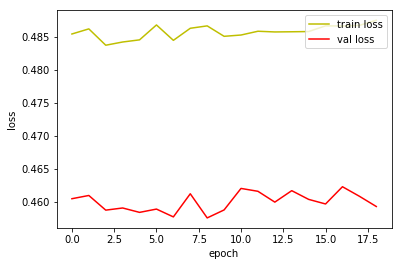

Fold 3 LogLoss : 0.4593264110064408
Train on 71262 samples, validate on 17815 samples
Epoch 1/30
71262/71262 [==============================] - 4s 61us/step - loss: 0.4860 - acc: 0.7780 - val_loss: 0.4554 - val_acc: 0.7925
Epoch 2/30
71262/71262 [==============================] - 4s 59us/step - loss: 0.4884 - acc: 0.7756 - val_loss: 0.4597 - val_acc: 0.7928
Epoch 3/30
71262/71262 [==============================] - 4s 60us/step - loss: 0.4868 - acc: 0.7756 - val_loss: 0.4585 - val_acc: 0.7919
Epoch 4/30
71262/71262 [==============================] - 4s 59us/step - loss: 0.4858 - acc: 0.7767 - val_loss: 0.4572 - val_acc: 0.7924
Epoch 5/30
71262/71262 [==============================] - 4s 59us/step - loss: 0.4864 - acc: 0.7756 - val_loss: 0.4575 - val_acc: 0.7932
Epoch 6/30
71262/71262 [==============================] - 4s 61us/step - loss: 0.4881 - acc: 0.7762 - val_loss: 0.4559 - val_acc: 0.7926
Epoch 7/30
71262/71262 [==============================] - 4s 60us/step - loss: 0.4859 - acc:

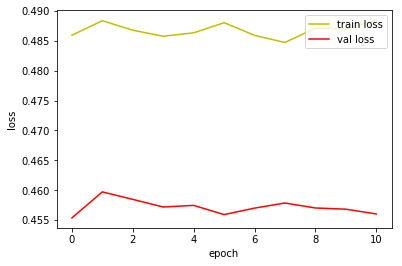

Fold 4 LogLoss : 0.45602451562426655
Train on 71262 samples, validate on 17815 samples
Epoch 1/30
71262/71262 [==============================] - 4s 60us/step - loss: 0.4864 - acc: 0.7755 - val_loss: 0.4550 - val_acc: 0.7916
Epoch 2/30
71262/71262 [==============================] - 4s 59us/step - loss: 0.4880 - acc: 0.7749 - val_loss: 0.4568 - val_acc: 0.7919
Epoch 3/30
71262/71262 [==============================] - 4s 59us/step - loss: 0.4864 - acc: 0.7765 - val_loss: 0.4569 - val_acc: 0.7897
Epoch 4/30
71262/71262 [==============================] - 4s 60us/step - loss: 0.4867 - acc: 0.7750 - val_loss: 0.4590 - val_acc: 0.7917
Epoch 5/30
71262/71262 [==============================] - 4s 61us/step - loss: 0.4862 - acc: 0.7770 - val_loss: 0.4582 - val_acc: 0.7925
Epoch 6/30
71262/71262 [==============================] - 4s 62us/step - loss: 0.4874 - acc: 0.7759 - val_loss: 0.4569 - val_acc: 0.7938
Epoch 7/30
71262/71262 [==============================] - 5s 68us/step - loss: 0.4872 - acc

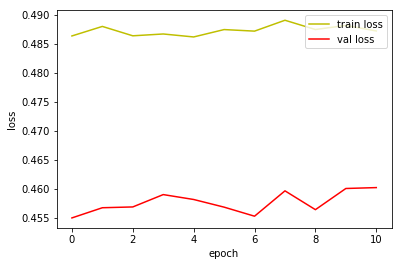

Fold 5 LogLoss : 0.4602437103031255
Best Epoch:  29
Total LogLoss 0.4581562143780564
Baseline model Score Diff -0.08989997932608706


In [30]:
all_data = pd.concat([train, test])
del all_data['oil_Type']

all_column_set = set(all_data.columns)
category_feature = []
for col in all_data.loc[:, all_data.dtypes=='object'].columns:
    all_data[col] = all_data[col].factorize()[0]
    category_feature.append(col)

numerical_feature = list(all_column_set - set(category_feature) - set(['Cover_Type','ID']))

all_data['Aspect'].fillna(all_data['Aspect'].mean(), inplace=True)
all_data['Elevation'] = np.log1p(all_data['Elevation'])

all_data = outlier_binary(all_data, 'Horizontal_Distance_To_Fire_Points', 10000)
all_data = outlier_binary(all_data, 'Horizontal_Distance_To_Roadways', 10000)

all_data = outlier_divide_ratio(all_data, 'Horizontal_Distance_To_Fire_Points', 10000)
all_data = outlier_divide_ratio(all_data, 'Horizontal_Distance_To_Roadways', 10000)

train_df = all_data.iloc[:train_index]
test_df = all_data.iloc[train_index:]

sc = StandardScaler()
train_df[numerical_feature] = sc.fit_transform(train_df[numerical_feature])
test_df[numerical_feature] = sc.transform(test_df[numerical_feature] )

baseline_keras_cv(train_df)

## Neural Network는 One Hot Encoding으로 성능이 올라갈까?
Neural Network Model은 Category Feature를 그대로 사용하면(Label Encoding) 성능이 안좋다고 합니다.<br>
같은 차원에서 데이터를 나눌 수 없어 독립된 다른 차원으로 보내야 한다고 합니다.<br>
그래서 흔히 사용하는 방법이 One Hot Encoding과 Entity Embedding 방법입니다. <br>
One Hot Encoding은 차원이 아주 많아지는 단점이 있고 Category간의 유사성을 파악하기 힘듭니다.<br>
요새 나온 우승자 솔루션들 보면 거의 Entity Embedding을 사용하고 있습니다.<br>
One Hot과 Entity Embedding의 성능을 비교해보는 것이 좋은데, 그것은 제가 이번에 준비하지 못해서 공부할 수 있는 Link만 걸어드릴게요<br>
꼭 사용해보세요<br>
https://www.kaggle.com/youhanlee/simple-eda-entity-embedding - 이유한님 Kernel<br>
https://www.kaggle.com/aquatic/entity-embedding-neural-net - Joe Eddy Kaggle Kernel<br>
https://medium.com/@satnalikamayank12/on-learning-embeddings-for-categorical-data-using-keras-165ff2773fc9 - 위 Kaggle Kernel을 설명한 <br>
https://github.com/entron/entity-embedding-rossmann <br>
http://www.fast.ai/2018/04/29/categorical-embeddings/ <br>
https://arxiv.org/abs/1604.06737 <br>

Train on 71261 samples, validate on 17816 samples
Epoch 1/30
71261/71261 [==============================] - 6s 78us/step - loss: 0.5061 - acc: 0.7541 - val_loss: 0.4463 - val_acc: 0.7969
Epoch 2/30
71261/71261 [==============================] - 5s 66us/step - loss: 0.4643 - acc: 0.7850 - val_loss: 0.4327 - val_acc: 0.8038
Epoch 3/30
71261/71261 [==============================] - 5s 67us/step - loss: 0.4507 - acc: 0.7911 - val_loss: 0.4186 - val_acc: 0.8085
Epoch 4/30
71261/71261 [==============================] - 5s 65us/step - loss: 0.4431 - acc: 0.7952 - val_loss: 0.4103 - val_acc: 0.8109
Epoch 5/30
71261/71261 [==============================] - 5s 65us/step - loss: 0.4360 - acc: 0.7988 - val_loss: 0.4040 - val_acc: 0.8162
Epoch 6/30
71261/71261 [==============================] - 5s 66us/step - loss: 0.4313 - acc: 0.7995 - val_loss: 0.3963 - val_acc: 0.8216
Epoch 7/30
71261/71261 [==============================] - 4s 62us/step - loss: 0.4250 - acc: 0.8047 - val_loss: 0.3899 - val_acc

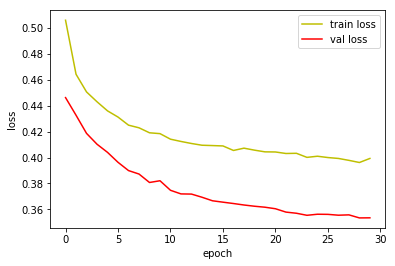

Fold 1 LogLoss : 0.3534160312546825
Train on 71261 samples, validate on 17816 samples
Epoch 1/30
71261/71261 [==============================] - 5s 70us/step - loss: 0.4004 - acc: 0.8177 - val_loss: 0.3465 - val_acc: 0.8483
Epoch 2/30
71261/71261 [==============================] - 5s 70us/step - loss: 0.3992 - acc: 0.8191 - val_loss: 0.3442 - val_acc: 0.8485
Epoch 3/30
71261/71261 [==============================] - 5s 66us/step - loss: 0.3997 - acc: 0.8184 - val_loss: 0.3441 - val_acc: 0.8483
Epoch 4/30
71261/71261 [==============================] - 5s 65us/step - loss: 0.3992 - acc: 0.8181 - val_loss: 0.3466 - val_acc: 0.8500
Epoch 5/30
71261/71261 [==============================] - 5s 65us/step - loss: 0.3984 - acc: 0.8197 - val_loss: 0.3431 - val_acc: 0.8485
Epoch 6/30
71261/71261 [==============================] - 5s 65us/step - loss: 0.3995 - acc: 0.8192 - val_loss: 0.3446 - val_acc: 0.8505
Epoch 7/30
71261/71261 [==============================] - 5s 68us/step - loss: 0.3969 - acc:

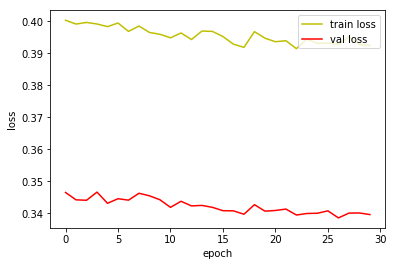

Fold 2 LogLoss : 0.33961526479404835
Train on 71262 samples, validate on 17815 samples
Epoch 1/30
71262/71262 [==============================] - 4s 61us/step - loss: 0.3920 - acc: 0.8226 - val_loss: 0.3418 - val_acc: 0.8502
Epoch 2/30
71262/71262 [==============================] - 4s 60us/step - loss: 0.3908 - acc: 0.8225 - val_loss: 0.3423 - val_acc: 0.8484
Epoch 3/30
71262/71262 [==============================] - 4s 61us/step - loss: 0.3922 - acc: 0.8228 - val_loss: 0.3437 - val_acc: 0.8481
Epoch 4/30
71262/71262 [==============================] - 4s 62us/step - loss: 0.3929 - acc: 0.8218 - val_loss: 0.3432 - val_acc: 0.8477
Epoch 5/30
71262/71262 [==============================] - 4s 61us/step - loss: 0.3929 - acc: 0.8211 - val_loss: 0.3448 - val_acc: 0.8482
Epoch 6/30
71262/71262 [==============================] - 4s 59us/step - loss: 0.3896 - acc: 0.8221 - val_loss: 0.3448 - val_acc: 0.8484
Epoch 7/30
71262/71262 [==============================] - 4s 59us/step - loss: 0.3896 - acc

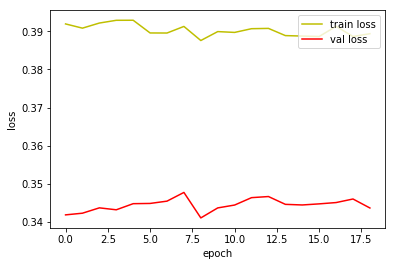

Fold 3 LogLoss : 0.3436539309743471
Train on 71262 samples, validate on 17815 samples
Epoch 1/30
71262/71262 [==============================] - 4s 61us/step - loss: 0.3920 - acc: 0.8211 - val_loss: 0.3356 - val_acc: 0.8574
Epoch 2/30
71262/71262 [==============================] - 4s 60us/step - loss: 0.3926 - acc: 0.8227 - val_loss: 0.3349 - val_acc: 0.8581
Epoch 3/30
71262/71262 [==============================] - 4s 60us/step - loss: 0.3925 - acc: 0.8201 - val_loss: 0.3369 - val_acc: 0.8556
Epoch 4/30
71262/71262 [==============================] - 4s 59us/step - loss: 0.3924 - acc: 0.8210 - val_loss: 0.3361 - val_acc: 0.8565
Epoch 5/30
71262/71262 [==============================] - 4s 60us/step - loss: 0.3918 - acc: 0.8235 - val_loss: 0.3363 - val_acc: 0.8540
Epoch 6/30
71262/71262 [==============================] - 4s 58us/step - loss: 0.3910 - acc: 0.8225 - val_loss: 0.3335 - val_acc: 0.8555
Epoch 7/30
71262/71262 [==============================] - 4s 58us/step - loss: 0.3907 - acc:

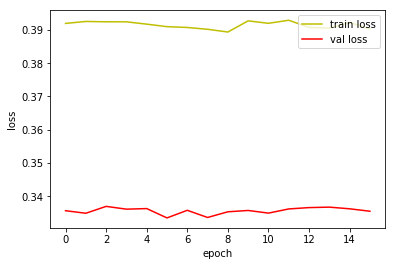

Fold 4 LogLoss : 0.33546514711712244
Train on 71262 samples, validate on 17815 samples
Epoch 1/30
71262/71262 [==============================] - 4s 59us/step - loss: 0.3900 - acc: 0.8225 - val_loss: 0.3346 - val_acc: 0.8539
Epoch 2/30
71262/71262 [==============================] - 4s 60us/step - loss: 0.3920 - acc: 0.8207 - val_loss: 0.3335 - val_acc: 0.8534
Epoch 3/30
71262/71262 [==============================] - 4s 60us/step - loss: 0.3900 - acc: 0.8223 - val_loss: 0.3357 - val_acc: 0.8548
Epoch 4/30
71262/71262 [==============================] - 4s 59us/step - loss: 0.3890 - acc: 0.8258 - val_loss: 0.3339 - val_acc: 0.8543
Epoch 5/30
71262/71262 [==============================] - 4s 61us/step - loss: 0.3898 - acc: 0.8247 - val_loss: 0.3354 - val_acc: 0.8530
Epoch 6/30
71262/71262 [==============================] - 4s 62us/step - loss: 0.3897 - acc: 0.8213 - val_loss: 0.3373 - val_acc: 0.8534
Epoch 7/30
71262/71262 [==============================] - 4s 59us/step - loss: 0.3921 - acc

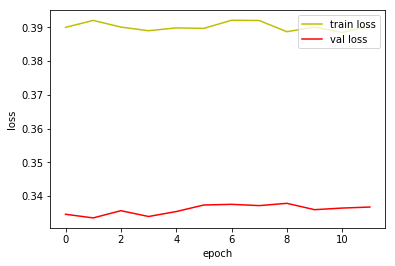

Fold 5 LogLoss : 0.33673907620109966
Best Epoch:  29
Total LogLoss 0.34177789006826
Baseline model Score Diff -0.2062783036358835


In [31]:
all_data = pd.concat([train, test])
del all_data['oil_Type']

all_column_set = set(all_data.columns)
category_feature = []
for col in all_data.loc[:, all_data.dtypes=='object'].columns:
    all_data = pd.concat([all_data,pd.get_dummies(all_data[col],prefix=col)],axis=1)
    category_feature.append(col)
    del all_data[col]
    
numerical_feature = list(all_column_set - set(category_feature) - set(['Cover_Type','ID']))

all_data['Aspect'].fillna(all_data['Aspect'].mean(), inplace=True)
all_data['Elevation'] = np.log1p(all_data['Elevation'])

all_data = outlier_binary(all_data, 'Horizontal_Distance_To_Fire_Points', 10000)
all_data = outlier_binary(all_data, 'Horizontal_Distance_To_Roadways', 10000)

all_data = outlier_divide_ratio(all_data, 'Horizontal_Distance_To_Fire_Points', 10000)
all_data = outlier_divide_ratio(all_data, 'Horizontal_Distance_To_Roadways', 10000)

train_df = all_data.iloc[:train_index]
test_df = all_data.iloc[train_index:]

sc = StandardScaler()
train_df[numerical_feature] = sc.fit_transform(train_df[numerical_feature])
test_df[numerical_feature] = sc.transform(test_df[numerical_feature] )

baseline_keras_cv(train_df)

## 알려진대로 NeuralNetwork는 OneHot을 해야합니다
## 성능이 꽤 많이 올라가서 기분이 좋네요

## 아까 mean으로 채운 NULL 값을 제대로 채워볼까요?
문제를 변환해서 Aspect 값의 NULL 값을 Test로 놓고 값이 있는 것을 Train으로 놓습니다.<br>
KNN을 사용하여 Aspect 값을 채워보도록 하겠습니다. <br>

코드가 좀 긴데 잘 따라와주세요~<br>
아래는 까지는 기본 Feature 추가한 것입니다.

In [32]:
all_data = pd.concat([train, test])
del all_data['oil_Type']

all_column_set = set(all_data.columns)
category_feature = []
for col in all_data.loc[:, all_data.dtypes=='object'].columns:
    all_data = pd.concat([all_data,pd.get_dummies(all_data[col],prefix=col)],axis=1)
    category_feature.append(col)
    del all_data[col]
    
numerical_feature = list(all_column_set - set(category_feature) - set(['Cover_Type','ID']))

# all_data['Aspect'].fillna(all_data['Aspect'].mean(), inplace=True)
all_data['Elevation'] = np.log1p(all_data['Elevation'])

all_data = outlier_binary(all_data, 'Horizontal_Distance_To_Fire_Points', 10000)
all_data = outlier_binary(all_data, 'Horizontal_Distance_To_Roadways', 10000)

all_data = outlier_divide_ratio(all_data, 'Horizontal_Distance_To_Fire_Points', 10000)
all_data = outlier_divide_ratio(all_data, 'Horizontal_Distance_To_Roadways', 10000)

In [33]:
all_data['Aspect'].isnull().sum()

17461

Aspect 값이 Null인 것은 Test, Null이 아닌 것은 Train으로 놓습니다. 그리고 Cover_Type과 ID값은 지워줍니다.

In [34]:
aspect_train = all_data.loc[all_data['Aspect'].notnull()]
aspect_test = all_data.loc[all_data['Aspect'].isnull()]
del aspect_train["Cover_Type"], aspect_train['ID']
del aspect_test["Cover_Type"], aspect_test['ID']

KNN은 거리기반 알고리즘이기 때문에 Scale에 민감합니다. Aspect 값을 제외하고 모두 StandardScale을 해줍니다.

In [35]:
numerical_feature_woaspect = numerical_feature[:]
numerical_feature_woaspect.remove('Aspect')

sc = StandardScaler()
aspect_train[numerical_feature_woaspect] = sc.fit_transform(aspect_train[numerical_feature_woaspect])
aspect_test[numerical_feature_woaspect] = sc.transform(aspect_test[numerical_feature_woaspect] )

그 후 Train, Test Set을 준비하는 것처럼 y값을 따로 빼주고 Aspect Column을 제거합니다.

In [36]:
y_value = aspect_train['Aspect']
del aspect_train['Aspect'], aspect_test['Aspect']

Sklearn에 KNeighborsRegressor 을 불러와서 알고리즘을 실행합니다. K값은 Tuning이 필요한데요.<br>
CV 값을 보고 하여습니다. 여기서는 하드하게 튜닝하지 않고 적당히 하고 넘어가도록 하겠습니다. <br>

In [37]:
knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(aspect_train,y_value)
predict = knn.predict(aspect_test)

predict와 원래 값의 분포를 보면 거의 비슷하게 Impuation 된것을 볼 수 있습니다. predict값을 원래 데이터에 넣고 성능을 측정해봅니다.

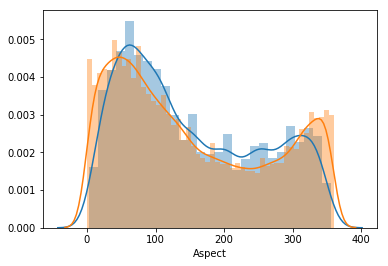

In [38]:
sns.distplot(predict)
sns.distplot(all_data['Aspect'].dropna())
plt.show()

In [39]:
all_data.loc[all_data['Aspect'].isnull(),'Aspect'] = predict

train_df = all_data.iloc[:train_index]
test_df = all_data.iloc[train_index:]

sc = StandardScaler()
train_df[numerical_feature] = sc.fit_transform(train_df[numerical_feature])
test_df[numerical_feature] = sc.transform(test_df[numerical_feature] )

Train on 71261 samples, validate on 17816 samples
Epoch 1/30
71261/71261 [==============================] - 5s 76us/step - loss: 0.5114 - acc: 0.7509 - val_loss: 0.4481 - val_acc: 0.7965
Epoch 2/30
71261/71261 [==============================] - 4s 61us/step - loss: 0.4667 - acc: 0.7833 - val_loss: 0.4360 - val_acc: 0.8044
Epoch 3/30
71261/71261 [==============================] - 4s 60us/step - loss: 0.4536 - acc: 0.7900 - val_loss: 0.4222 - val_acc: 0.8091
Epoch 4/30
71261/71261 [==============================] - 4s 60us/step - loss: 0.4464 - acc: 0.7932 - val_loss: 0.4121 - val_acc: 0.8129
Epoch 5/30
71261/71261 [==============================] - 4s 60us/step - loss: 0.4384 - acc: 0.7966 - val_loss: 0.4070 - val_acc: 0.8165
Epoch 6/30
71261/71261 [==============================] - 4s 59us/step - loss: 0.4320 - acc: 0.8003 - val_loss: 0.3983 - val_acc: 0.8208
Epoch 7/30
71261/71261 [==============================] - 4s 59us/step - loss: 0.4282 - acc: 0.8024 - val_loss: 0.3939 - val_acc

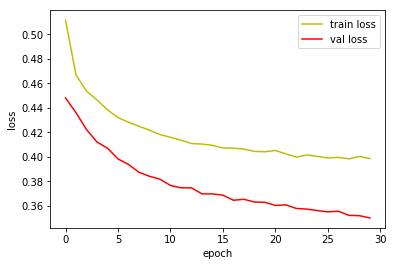

Fold 1 LogLoss : 0.35022809596832477
Train on 71261 samples, validate on 17816 samples
Epoch 1/30
71261/71261 [==============================] - 4s 59us/step - loss: 0.3981 - acc: 0.8177 - val_loss: 0.3483 - val_acc: 0.8473
Epoch 2/30
71261/71261 [==============================] - 4s 61us/step - loss: 0.3994 - acc: 0.8186 - val_loss: 0.3453 - val_acc: 0.8475
Epoch 3/30
71261/71261 [==============================] - 4s 59us/step - loss: 0.3985 - acc: 0.8172 - val_loss: 0.3482 - val_acc: 0.8496
Epoch 4/30
71261/71261 [==============================] - 4s 58us/step - loss: 0.3979 - acc: 0.8193 - val_loss: 0.3459 - val_acc: 0.8485
Epoch 5/30
71261/71261 [==============================] - 4s 59us/step - loss: 0.3971 - acc: 0.8187 - val_loss: 0.3442 - val_acc: 0.8481
Epoch 6/30
71261/71261 [==============================] - 4s 59us/step - loss: 0.3957 - acc: 0.8208 - val_loss: 0.3437 - val_acc: 0.8478
Epoch 7/30
71261/71261 [==============================] - 4s 60us/step - loss: 0.3977 - acc

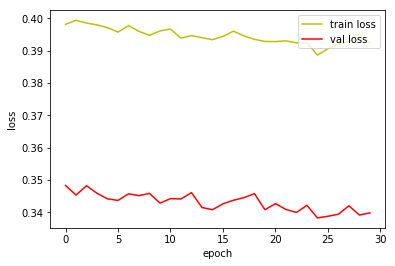

Fold 2 LogLoss : 0.3398359956929052
Train on 71262 samples, validate on 17815 samples
Epoch 1/30
71262/71262 [==============================] - 4s 59us/step - loss: 0.3911 - acc: 0.8231 - val_loss: 0.3422 - val_acc: 0.8515
Epoch 2/30
71262/71262 [==============================] - 4s 61us/step - loss: 0.3887 - acc: 0.8237 - val_loss: 0.3443 - val_acc: 0.8495
Epoch 3/30
71262/71262 [==============================] - 4s 59us/step - loss: 0.3901 - acc: 0.8224 - val_loss: 0.3432 - val_acc: 0.8505
Epoch 4/30
71262/71262 [==============================] - 4s 59us/step - loss: 0.3874 - acc: 0.8227 - val_loss: 0.3428 - val_acc: 0.8482
Epoch 5/30
71262/71262 [==============================] - 4s 58us/step - loss: 0.3892 - acc: 0.8239 - val_loss: 0.3439 - val_acc: 0.8499
Epoch 6/30
71262/71262 [==============================] - 4s 61us/step - loss: 0.3904 - acc: 0.8222 - val_loss: 0.3428 - val_acc: 0.8517
Epoch 7/30
71262/71262 [==============================] - 6s 81us/step - loss: 0.3870 - acc:

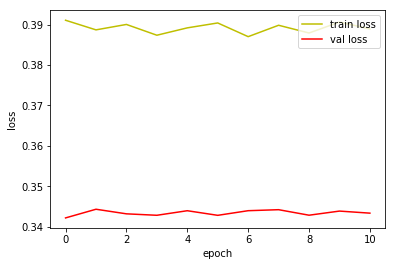

Fold 3 LogLoss : 0.34334167343903677
Train on 71262 samples, validate on 17815 samples
Epoch 1/30
71262/71262 [==============================] - 4s 60us/step - loss: 0.3935 - acc: 0.8212 - val_loss: 0.3356 - val_acc: 0.8565
Epoch 2/30
71262/71262 [==============================] - 4s 58us/step - loss: 0.3919 - acc: 0.8214 - val_loss: 0.3365 - val_acc: 0.8565
Epoch 3/30
71262/71262 [==============================] - 4s 59us/step - loss: 0.3920 - acc: 0.8208 - val_loss: 0.3386 - val_acc: 0.8549
Epoch 4/30
71262/71262 [==============================] - 4s 58us/step - loss: 0.3880 - acc: 0.8228 - val_loss: 0.3348 - val_acc: 0.8570
Epoch 5/30
71262/71262 [==============================] - 4s 58us/step - loss: 0.3891 - acc: 0.8232 - val_loss: 0.3358 - val_acc: 0.8532
Epoch 6/30
71262/71262 [==============================] - 4s 60us/step - loss: 0.3904 - acc: 0.8222 - val_loss: 0.3366 - val_acc: 0.8543
Epoch 7/30
71262/71262 [==============================] - 4s 58us/step - loss: 0.3929 - acc

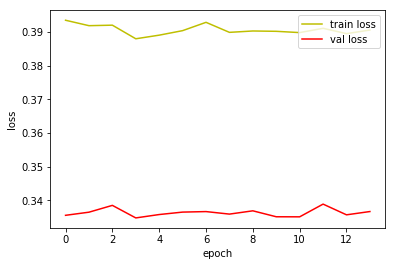

Fold 4 LogLoss : 0.3367224051200924
Train on 71262 samples, validate on 17815 samples
Epoch 1/30
71262/71262 [==============================] - 5s 63us/step - loss: 0.3874 - acc: 0.8247 - val_loss: 0.3307 - val_acc: 0.8578
Epoch 2/30
71262/71262 [==============================] - 4s 60us/step - loss: 0.3913 - acc: 0.8219 - val_loss: 0.3327 - val_acc: 0.8589
Epoch 3/30
71262/71262 [==============================] - 4s 59us/step - loss: 0.3923 - acc: 0.8218 - val_loss: 0.3317 - val_acc: 0.8571
Epoch 4/30
71262/71262 [==============================] - 4s 58us/step - loss: 0.3895 - acc: 0.8229 - val_loss: 0.3326 - val_acc: 0.8567
Epoch 5/30
71262/71262 [==============================] - 4s 60us/step - loss: 0.3892 - acc: 0.8234 - val_loss: 0.3333 - val_acc: 0.8564
Epoch 6/30
71262/71262 [==============================] - 4s 58us/step - loss: 0.3889 - acc: 0.8240 - val_loss: 0.3353 - val_acc: 0.8542
Epoch 7/30
71262/71262 [==============================] - 4s 59us/step - loss: 0.3924 - acc:

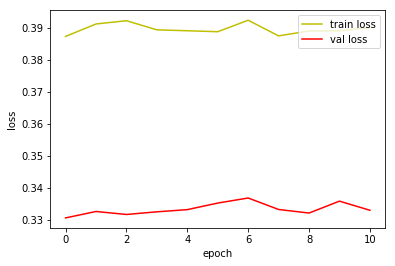

Fold 5 LogLoss : 0.333057309157154
Best Epoch:  29
Total LogLoss 0.3406370958755026
Baseline model Score Diff -0.20741909782864087


In [40]:
baseline_keras_cv(train_df)

# 지금까지 정제한 Feature로 Tree Model에도 사용해보도록 하겠습니다.
tree 모델엔 One Hot을 사용하지 않고 Label Encoding만 해주도록 하겠습니다.

Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.324007	valid_1's binary_logloss: 0.34284
[1000]	training's binary_logloss: 0.269898	valid_1's binary_logloss: 0.298253
[1500]	training's binary_logloss: 0.232649	valid_1's binary_logloss: 0.271176
[2000]	training's binary_logloss: 0.204745	valid_1's binary_logloss: 0.251607
[2500]	training's binary_logloss: 0.18242	valid_1's binary_logloss: 0.238502
[3000]	training's binary_logloss: 0.163143	valid_1's binary_logloss: 0.226388
Did not meet early stopping. Best iteration is:
[3000]	training's binary_logloss: 0.163143	valid_1's binary_logloss: 0.226388
Fold 1 LogLoss : 0.22638810092957734


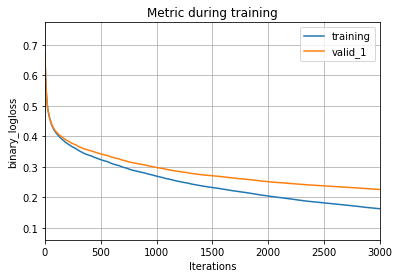

Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.319736	valid_1's binary_logloss: 0.337169
[1000]	training's binary_logloss: 0.266214	valid_1's binary_logloss: 0.295044
[1500]	training's binary_logloss: 0.229689	valid_1's binary_logloss: 0.268316
[2000]	training's binary_logloss: 0.203493	valid_1's binary_logloss: 0.250637
[2500]	training's binary_logloss: 0.181102	valid_1's binary_logloss: 0.236712
[3000]	training's binary_logloss: 0.162877	valid_1's binary_logloss: 0.226326
Did not meet early stopping. Best iteration is:
[3000]	training's binary_logloss: 0.162877	valid_1's binary_logloss: 0.226326
Fold 2 LogLoss : 0.2263261412097427


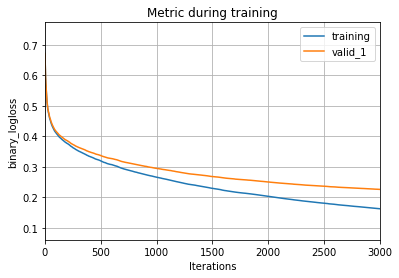

Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.31961	valid_1's binary_logloss: 0.342591
[1000]	training's binary_logloss: 0.265654	valid_1's binary_logloss: 0.30078
[1500]	training's binary_logloss: 0.230512	valid_1's binary_logloss: 0.276228
[2000]	training's binary_logloss: 0.203879	valid_1's binary_logloss: 0.258105
[2500]	training's binary_logloss: 0.181717	valid_1's binary_logloss: 0.243462
[3000]	training's binary_logloss: 0.163144	valid_1's binary_logloss: 0.231772
Did not meet early stopping. Best iteration is:
[3000]	training's binary_logloss: 0.163144	valid_1's binary_logloss: 0.231772
Fold 3 LogLoss : 0.2317723515696694


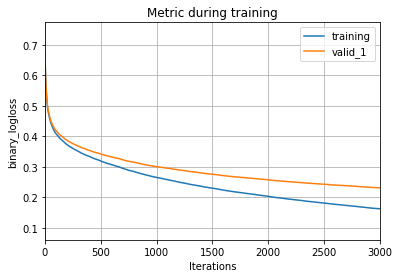

Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.322276	valid_1's binary_logloss: 0.340371
[1000]	training's binary_logloss: 0.266979	valid_1's binary_logloss: 0.297157
[1500]	training's binary_logloss: 0.230039	valid_1's binary_logloss: 0.269726
[2000]	training's binary_logloss: 0.202441	valid_1's binary_logloss: 0.251167
[2500]	training's binary_logloss: 0.180363	valid_1's binary_logloss: 0.23762
[3000]	training's binary_logloss: 0.162189	valid_1's binary_logloss: 0.22744
Did not meet early stopping. Best iteration is:
[3000]	training's binary_logloss: 0.162189	valid_1's binary_logloss: 0.22744
Fold 4 LogLoss : 0.22744018526332996


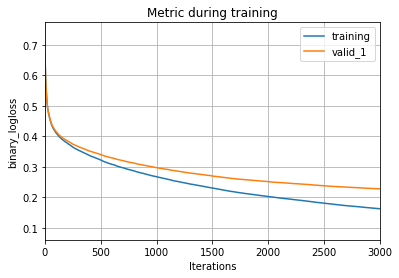

Training until validation scores don't improve for 200 rounds.
[500]	training's binary_logloss: 0.323281	valid_1's binary_logloss: 0.342949
[1000]	training's binary_logloss: 0.26709	valid_1's binary_logloss: 0.298428
[1500]	training's binary_logloss: 0.230958	valid_1's binary_logloss: 0.272952
[2000]	training's binary_logloss: 0.202696	valid_1's binary_logloss: 0.25358
[2500]	training's binary_logloss: 0.180472	valid_1's binary_logloss: 0.239673
[3000]	training's binary_logloss: 0.1625	valid_1's binary_logloss: 0.228847
Did not meet early stopping. Best iteration is:
[3000]	training's binary_logloss: 0.1625	valid_1's binary_logloss: 0.228847
Fold 5 LogLoss : 0.22884709456824143


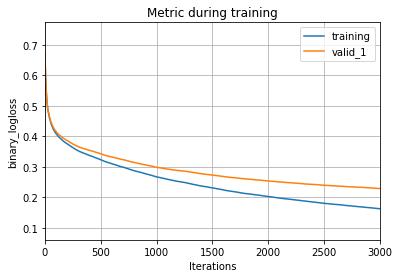

Best Iteration 3000
Total LogLoss 0.22815477470811216
Baseline model Score Diff -0.0027680139391189906


3000

In [41]:
all_data = pd.concat([train, test])
del all_data['oil_Type']

all_column_set = set(all_data.columns)
category_feature = []
for col in all_data.loc[:, all_data.dtypes=='object'].columns:
    all_data[col] = all_data[col].factorize()[0]
    category_feature.append(col)
    
numerical_feature = list(all_column_set - set(category_feature) - set(['Cover_Type','ID']))

# all_data['Aspect'].fillna(all_data['Aspect'].mean(), inplace=True)
all_data['Elevation'] = np.log1p(all_data['Elevation'])

all_data = outlier_binary(all_data, 'Horizontal_Distance_To_Fire_Points', 10000)
all_data = outlier_binary(all_data, 'Horizontal_Distance_To_Roadways', 10000)

all_data = outlier_divide_ratio(all_data, 'Horizontal_Distance_To_Fire_Points', 10000)
all_data = outlier_divide_ratio(all_data, 'Horizontal_Distance_To_Roadways', 10000)

aspect_train = all_data.loc[all_data['Aspect'].notnull()]
aspect_test = all_data.loc[all_data['Aspect'].isnull()]
del aspect_train["Cover_Type"], aspect_train['ID']
del aspect_test["Cover_Type"], aspect_test['ID']

numerical_feature_woaspect = numerical_feature[:]
numerical_feature_woaspect.remove('Aspect')

sc = StandardScaler()
aspect_train[numerical_feature_woaspect] = sc.fit_transform(aspect_train[numerical_feature_woaspect])
aspect_test[numerical_feature_woaspect] = sc.transform(aspect_test[numerical_feature_woaspect] )

y_value = aspect_train['Aspect']
del aspect_train['Aspect'], aspect_test['Aspect']

knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(aspect_train,y_value)
predict = knn.predict(aspect_test)

all_data.loc[all_data['Aspect'].isnull(),'Aspect'] = predict

train_df = all_data.iloc[:train_index]
test_df = all_data.iloc[train_index:]

baseline_tree_cv(train_df)

## CategoryData를 Frequency Encoding 해볼게요
Category Data는 2개가 있습니다.

In [42]:
category_feature

['Soil_Type', 'Wilderness_Area']

In [43]:
all_data = pd.concat([train_df, test_df])

In [44]:
soil_freq_encoding = all_data.groupby(['Soil_Type']).size()/all_data.shape[0]
soil_freq_encoding = soil_freq_encoding.reset_index().rename(columns={0:'Soil_Frequncy'})
all_data = all_data.merge(soil_freq_encoding, on='Soil_Type', how='left')

In [45]:
def frequency_encoding(frame, col):
    freq_encoding = frame.groupby([col]).size()/all_data.shape[0] 
    freq_encoding = freq_encoding.reset_index().rename(columns={0:'{}_Frequncy'.format(col)})
    return frame.merge(freq_encoding, on=col, how='left')

In [46]:
all_data = frequency_encoding(all_data, 'Wilderness_Area')

In [47]:
train_df = all_data.iloc[:train_index]
test_df = all_data.iloc[train_index:]

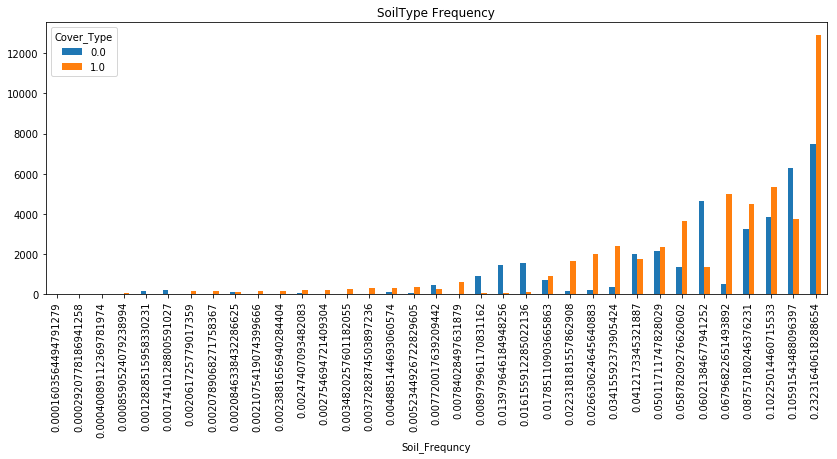

In [48]:
frequency_df = train_df.groupby(['Soil_Frequncy','Cover_Type'])['Soil_Frequncy'].count().unstack('Cover_Type')
frequency_df.plot(kind='bar', figsize=(14,5))
plt.title('SoilType Frequency')
plt.show()

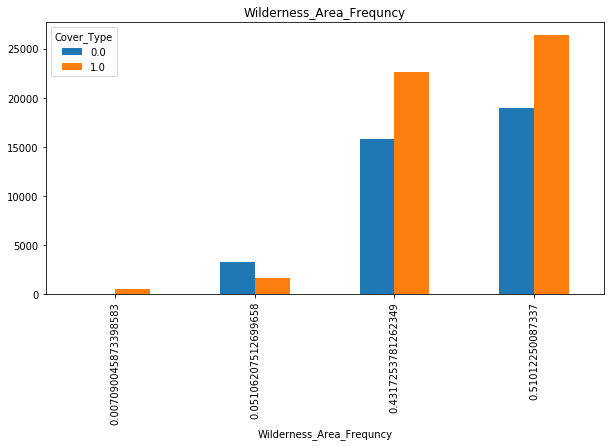

In [49]:
frequency_df = train_df.groupby(['Wilderness_Area_Frequncy','Cover_Type'])['Wilderness_Area_Frequncy'].count().unstack('Cover_Type')
frequency_df.plot(kind='bar', figsize=(10,5))
plt.title('Wilderness_Area_Frequncy')
plt.show()

In [ ]:
all_data = pd.concat([train, test])
del all_data['oil_Type']

all_column_set = set(all_data.columns)
category_feature = []
for col in all_data.loc[:, all_data.dtypes=='object'].columns:
    all_data[col] = all_data[col].factorize()[0]
    category_feature.append(col)
    
numerical_feature = list(all_column_set - set(category_feature) - set(['Cover_Type','ID']))

# all_data['Aspect'].fillna(all_data['Aspect'].mean(), inplace=True)
all_data['Elevation'] = np.log1p(all_data['Elevation'])

all_data = outlier_binary(all_data, 'Horizontal_Distance_To_Fire_Points', 10000)
all_data = outlier_binary(all_data, 'Horizontal_Distance_To_Roadways', 10000)

all_data = outlier_divide_ratio(all_data, 'Horizontal_Distance_To_Fire_Points', 10000)
all_data = outlier_divide_ratio(all_data, 'Horizontal_Distance_To_Roadways', 10000)

all_data = frequency_encoding(all_data, 'Soil_Type')
all_data = frequency_encoding(all_data, 'Wilderness_Area')

aspect_train = all_data.loc[all_data['Aspect'].notnull()]
aspect_test = all_data.loc[all_data['Aspect'].isnull()]
del aspect_train["Cover_Type"], aspect_train['ID']
del aspect_test["Cover_Type"], aspect_test['ID']

numerical_feature_woaspect = numerical_feature[:]
numerical_feature_woaspect.remove('Aspect')

sc = StandardScaler()
aspect_train[numerical_feature_woaspect] = sc.fit_transform(aspect_train[numerical_feature_woaspect])
aspect_test[numerical_feature_woaspect] = sc.transform(aspect_test[numerical_feature_woaspect] )

y_value = aspect_train['Aspect']
del aspect_train['Aspect'], aspect_test['Aspect']

knn = KNeighborsRegressor(n_neighbors=7)
knn.fit(aspect_train,y_value)
predict = knn.predict(aspect_test)

sns.distplot(predict)
sns.distplot(all_data['Aspect'].dropna())
plt.show()

all_data.loc[all_data['Aspect'].isnull(),'Aspect'] = predict

train_df = all_data.iloc[:train_index]
test_df = all_data.iloc[train_index:]

baseline_tree_cv(train_df)